# A cooling coffee cup example

Some libraries that will be useful.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from torch import manual_seed
manual_seed(42)

## Theory

Let's say we have data on a phenomenon, but the data is incomplete - we can only measure a part of this phenomenon. We try to model the phenomenon, but our model breaks outside the unmeasured regions.
Now, it just so happens that some physicists have analysed this phenomenon before and devised a partial differential equation (PDE) describing it. How can we use this knowledge to inform our model on how it should behave in theory? What if we could somehow inform our model with the physics? That is what a physics-informed neural network (PINN) can do!

When training a neural network (NN) we use the loss - a distance measure between the true values and the predictions, to optimise the NN model to fit the data as best as possible. With not enough data, the model might overfit. Real data is often hard to come by.

Say we have a differential equation $g(x, y) = 0$, some data $\mathcal{D}$ and a neural network described by $f(x|\theta)$ that approximates $y$. For a PINN, we would get a loss function that looks like the following:

$$
    Loss_{PINN} = \underbrace{\frac{1}{N} \sum_{j}^{N} \| f(x_j|\theta) - y_j \|^2_2}_{\text{Data loss}} + \lambda \underbrace{\frac{1}{M} \sum_{i}^{M} \| g(x_i, f(x_i|\theta)) \|^2_2}_{\text{Physics loss}}
$$

where $x_i$ and $y_i$ are a single data point ($x_i$ are the _collocation_ points, where the PDE has an actual solution), and $\lambda$ is a scaling parameter. We can use $\lambda$ to control the relative strength of the data loss function and the physics loss function.

Now we can train our PINN like any other NN.

## Some caveats
- The PINN framework an equation that relates to the data. It is best suited for data that measures real-world physical phenomena. This data is, usually, noisy and hard to come by. Both of these drawbacks are helped by PINNs.
- Using very complex differential equations can make the optimisation process (training) harder. The more complex loss landscape gets too "bumpy" and gradient descent gets stuck [[1](#references)].

## Example

A cooling coffee cup obeys a simple law of physics (Newton's law of cooling in time only [[1](#references)]):

$$
    \frac{dT(t)}{dt} = r(T_{env} - T(t))
$$

where $T(t)$ is the temparature (changing over time $t$), $T_{env}$ is the temparature of the environment and $r$ is the cooling rate.

### Conditions
Let's assume that the coffee was boiling hot and is cooling over the course of around $15$ minutes in room temperature ($T_{env}=25^\text{o}\text{C}$) with a cooling rate $r = 0.005$.

In [2]:
# Temperature of the environment
Tenv = 25
# Initial temperature of the coffee
T0 = 100  # assuming the coffee starts at 100 degrees Celsius
# Cooling rate
r = 0.005

### Plotting the equation and measurement data

What does it look like? We make 10 initial measurements in the first 5 mins.

/tmp/ipykernel_1143597/841211166.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  real_T[i] = np.interp(real_t[i], t, T) + 2 * np.random.randn(1)


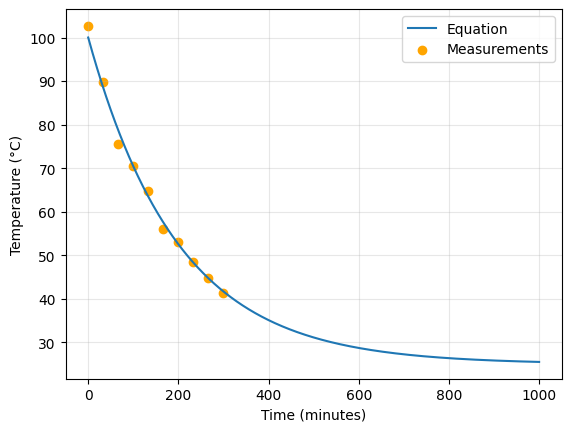

In [3]:
np.random.seed(10)

# Time points where we want to compute the temperature
t = np.linspace(0, 1000, 1000)

# Initialize temperature array
T = np.zeros_like(t)
T[0] = T0

# Euler method to solve the differential equation
for i in range(1, len(t)):
    dt = t[i] - t[i-1]
    T[i] = T[i-1] + r * (Tenv - T[i-1]) * dt

# Simulate 10 measurements of temperature for the first 5 minutes
real_t = np.linspace(0, 300, 10)
real_T = np.zeros_like(real_t)
for i in range(len(real_t)):
    real_T[i] = np.interp(real_t[i], t, T) + 2 * np.random.randn(1)

# Plotting the results
plt.plot(t, T, label='Equation')
plt.scatter(real_t, real_T, color='orange', label='Measurements')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.grid(linestyle='-', alpha=0.3)
plt.legend()

The simulated measurement samples have normally distributed noise with a standard deviation of $\sigma=2^\text{o}\text{C}$.

### Vanilla NN

Let's train a simple vanilla NN and see how it performs.

Epoch 0, loss 4707.62890625
Epoch 4000, loss 2140.096435546875
Epoch 8000, loss 71.45852661132812
Epoch 12000, loss 0.38146644830703735
Epoch 16000, loss 0.3226228356361389


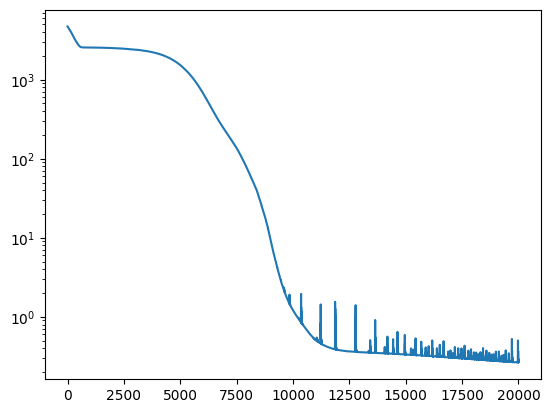

In [4]:
from net import Net
# Initialize the network
net = Net(1, 1, n_hidden=100)

# Train the network
from torch.nn import MSELoss
losses, preds = net.fit(real_t, real_T, n_epochs=20000, lr=1e-5, loss_fn=MSELoss(), test_set=t)

# plot losses
plt.plot(losses)
plt.yscale('log')

Visualize `VanillaNet`'s predictions as an animation.

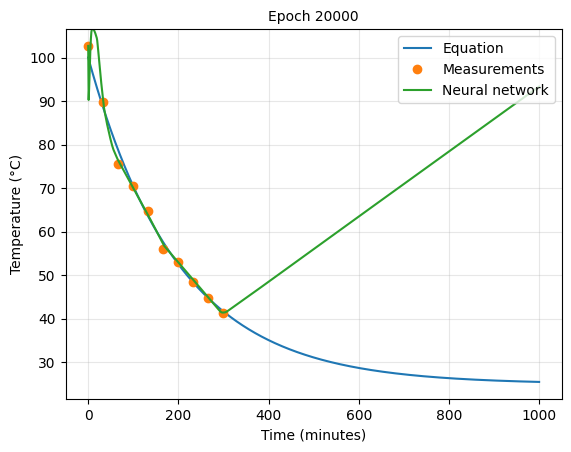

In [5]:
import matplotlib.animation as animation

def animate(predictions, epochs, save_as: str = None):
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Set up the plot limits and labels
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(linestyle='-', alpha=0.3)
    
    # Plot the equation and measurements
    ax.plot(t, T, label='Equation')
    ax.plot(real_t, real_T, 'o', label='Measurements')

    # Initialize the line object for the predictions
    line, = ax.plot([], [], label='Neural network')

    # Function to initialize the animation
    def init():
        line.set_data([], [])
        return line,

    # Function to update the animation
    def update(frame):
        line.set_data(t, predictions[frame])
        ax.set_title(f'Epoch {epochs[frame]}', fontsize=10)
        return line,

    # Create the animation with increased frames per second
    ani = animation.FuncAnimation(fig, update, frames=len(predictions), init_func=init, blit=True, interval=50)
    # Add legend
    ax.legend(loc='upper right')
    # Save the animation as a video file
    if save_as:
        ani.save(save_as, writer='ffmpeg')

# epochs
epochs = [0] + [i for i in range(0, 20000, 100)] + [20000]
# animate
animate(preds, epochs, save_as='figures/VanillaNN.mp4')

### PINN

If we have a neural network $f(t|\theta)$ that predicts the temperature of the cup $T$ given time $t$ then we can construct a physics loss of this data:

\begin{align*}
    g(t, T) &= \frac{dT(t)}{dt} - r(T_{\text{env}} - T(t)) = 0 \\
    g(t, f(t|\theta)) &= \frac{df(t|\theta)}{dt} - r(T_{\text{env}} - f(t|\theta))
\end{align*}

Adding this new loss formulation into the loss function for the PINN we get:

$$
    Loss_{PINN} = \underbrace{\frac{1}{10} \sum_j^{10} \left( f(t_j|\theta) - T_j \right)^2}_{\text{data loss}} + \lambda \underbrace{\frac{1}{M} \sum_i^M \left( \frac{df(t_i|\theta)}{dt_i} - r(T_{\text{env}} - f(t_i|\theta)) \right)^2}_{\text{physics loss}}
$$

The above formula includes a derivative of the NN model itself! That is $\frac{df(t_i|\theta)}{dt_i}$. Thankfully, `torch.autograd` has a `grad()` function performs that exact operation.

In [6]:
from torch import linspace, mean
from net import grad

def physics_loss(model):
    # collocation points
    ts = linspace(0, 1000, steps=1000).view(-1, 1).requires_grad_(True)  # needs gradient
    # run the collocation points through the network
    temps = model(ts)
    # the gradient
    dT = grad(temps, ts)[0]
    # compute the ODE
    ode = dT - r * (Tenv - temps)
    # MSE of ODE
    return mean(ode**2)

Now we can apply the physics loss to our vanilla NN and see how it impacts the model's performance. Training on 1000 collocation points.

Epoch 0, loss 4616.6650390625
Epoch 4000, loss 1945.873046875
Epoch 8000, loss 0.9842641949653625
Epoch 12000, loss 0.6386814117431641
Epoch 16000, loss 0.4554511308670044
Epoch 20000, loss 0.33618080615997314
Epoch 24000, loss 0.2615759074687958
Epoch 28000, loss 0.20678041875362396


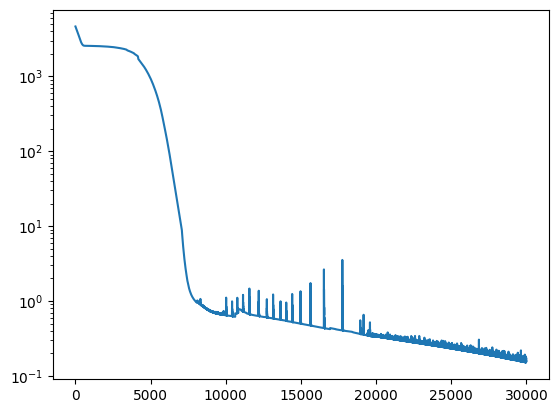

In [7]:
# start with a vanilla network again
net = Net(1, 1, n_hidden=100)

# Train the network
losses, preds_PINN = net.fit(real_t, real_T, n_epochs=30000, lr=1e-5, loss_fn=MSELoss(), loss2=physics_loss, loss2_weight=1, test_set=t)

# plot losses
plt.plot(losses)
plt.yscale('log')

So the network definitely learned something! Now, let's see how it performs.

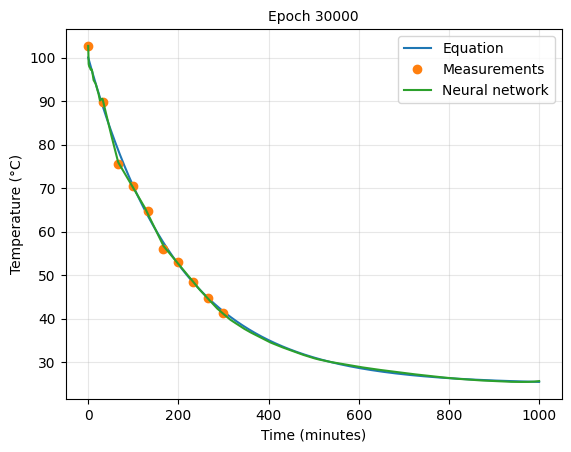

In [8]:
epochs = [0] + [i for i in range(0, 30000, 100)] + [30000]
# animate
animate(preds_PINN, epochs, save_as='figures/PINN.mp4')

Amazing! We can see that adding the additional loss (from physics) imporved the model's ability to predict the temperature beyond the data.

However, training the network to appropriately fit the data and the physics equation is a difficult task and the plot above shows how our model actually may be overfitting the training data.

Event though this is a simple example, it proves a point! This framework could be used on phenomena requiring more complex PDEs.

### Adding flexibility

The assumption that physics describes reality completely is not so far from the truth. However, it does not consider lots of other effects. For example, how the cooling rate is affected by the thickness and material of the coffee cup.


In [9]:
def physics_loss_discovery(model):
    ts = linspace(0, 1000, steps=1000).view(-1, 1).requires_grad_(True)  # needs gradient
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    return mean(pde**2)

Now we train a PINN with a discovery loss.

Epoch 0, loss 4769.49267578125
Epoch 4000, loss 2206.380859375
Epoch 8000, loss 9.734467506408691
Epoch 12000, loss 0.3439839780330658
Epoch 16000, loss 0.3368780314922333
Epoch 20000, loss 0.3578552305698395
Epoch 24000, loss 0.3366745710372925
Epoch 28000, loss 0.3280716836452484


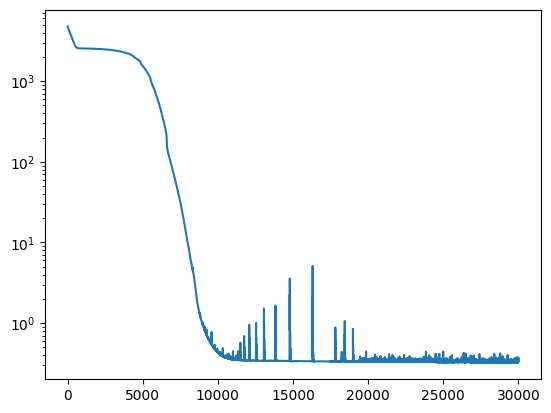

In [10]:
# start with a vanilla network again
net = Net(1, 1, n_hidden=100)

# Train the network
losses, preds_PINN_disc = net.fit(real_t, real_T, n_epochs=30000, lr=1e-5, loss_fn=MSELoss(), loss2=physics_loss_discovery, loss2_weight=1, test_set=t)

# plot losses
plt.plot(losses)
plt.yscale('log')

Learned cooling rate: 0.0052


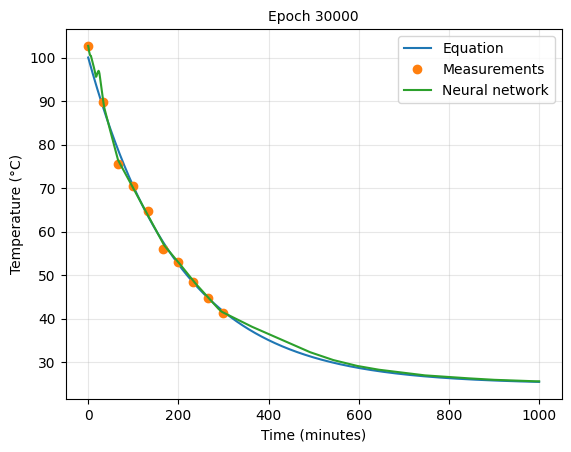

In [11]:
print(f'Learned cooling rate: {net.r.item():.4f}')

epochs = [0] + [i for i in range(0, 30000, 100)] + [30000]
# animate
animate(preds_PINN_disc, epochs, save_as='figures/PINN_discovery.mp4')

## References

[1] [Physics-informed Neural Networks: a simple tutorial with PyTorch](https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a)